In [329]:
#import dependencies
import pandas as pd
import numpy as np
import os
from datetime import datetime, date

import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from bokeh.palettes import Spectral11


from bokeh.plotting import figure, output_file, show
from bokeh.models.ranges import Range1d

import seaborn as sns

In [349]:
prices_df = pd.read_csv(f'../data/clean_data/hist_daily_stock_fut_price.csv', index_col = 0, parse_dates = True, infer_datetime_format = True)

prices_df = prices_df[['corn', 'cornf']]

returns_df = prices_df.pct_change().dropna()

prices_df.head(5)

,corn,cornf
2011-09-19,45.65,692.25
2011-09-20,45.54,690.25
2011-09-21,44.80,685.75
2011-09-22,42.99,650.00
2011-09-23,42.45,638.50


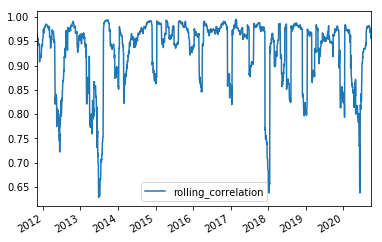

In [310]:
rolling_returns_df = returns_df.rolling(window = 30).mean().dropna()
# rolling_returns_df = rolling_returns_df.resample('MS').mean()

# rolling_vol_df = returns_df.rolling(window = 30).std().dropna()

rolling_corr_df = pd.DataFrame(returns_df['corn'].rolling(window = 30).corr(other = returns_df['cornf']).dropna(), columns = ['rolling_correlation'])
# rolling_corr_df = pd.DataFrame(rolling_corr_df.resample('MS').mean(), columns = ['monthly_avg_rolling_correlation'])

rolling_corr_plot = rolling_corr_df.plot()

plt.savefig(f'../images/jg_fig_temp.png')

# rolling_returns_df.plot(figsize = (20, 20))

In [315]:
price_data_df = rolling_returns_df.merge(rolling_corr_df, how = 'inner', right_index = True, left_index = True).reset_index()

price_data_df = price_data_df.rename(columns = {'index' : 'date', 'corn' : 'etf', 'cornf' : 'futures', 'rolling_correlation' : 'rolling_correlation'})

rolling_returns_df.head(1)

,date,etf,futures,rolling_correlation
0,2011-11-01,-0.000579,-0.000182,0.963418
1,2011-12-01,-0.002475,-0.001749,0.909373
2,2012-03-01,-0.000189,0.000969,0.980970
3,2012-06-01,0.000698,-0.000353,0.796289
4,2012-08-01,0.004899,0.005632,0.934744


In [336]:
price_data_df['etf'].dtypes

dtype('float64')

In [357]:
price_data_df = rolling_returns_df.merge(rolling_corr_df, how = 'inner', right_index = True, left_index = True).reset_index()

price_data_df = price_data_df.rename(columns = {'index' : 'date', 'corn' : 'etf', 'cornf' : 'futures', 'rolling_correlation' : 'rolling_correlation'})
# price_data_df['date'] = pd.to_datetime(price_data_df['date'], format = '%Y%m')

x_date = price_data_df['date']
y_etf = price_data_df['etf']
y_futures = price_data_df['futures']
y_correlation = price_data_df['rolling_correlation']

price_plot = figure(plot_width = 800, plot_height = 400, title = 'corn etf & futures daily returns', x_axis_label = 'date', y_axis_label = 'price ($)', x_axis_type = 'datetime')

price_plot.y_range = Range1d(min(y_etf.min(), y_futures.min()), max(y_etf.max(), y_futures.max()))
price_plot.line(x_date, y_etf, line_width = 3, color = 'DarkSlateGrey', legend_label = 'etf')
price_plot.line(x_date, y_futures, line_width = 3, color = 'CornflowerBlue', legend_label = 'futures')
# price_plot.extra_y_ranges = {'rolling_correlation' : Range1d(.7, 1)}
# price_plot.add_layout(LinearAxis(y_range_name = 'rolling_correlation', axis_label = 'correlation'), 'right')
# price_plot.line(x_date, y_correlation, line_width = 2, y_range_name = 'rolling_correlation', color = '#33A02C', legend_label = 'corn etf vs futures rolling correlation')
price_plot.xaxis.major_label_orientation = 'vertical'
price_plot.legend.location = 'bottom_right'

show(price_plot)

plt.savefig(f'../images/price_plot.png')

<Figure size 432x288 with 0 Axes>

In [29]:
usda_df = pd.read_csv(f'../data/clean_data/usda_data/usda_data_corn_grain.csv', index_col = False)

usda_df.head(1)

,commodity,sub_commodity,location,stat,unit,frequency,year,period,value
0,CORN,GRAIN,AL,PRODUCTION,$,ANNUAL,2000,YEAR,23166000.0


In [49]:
corn_df = usda_df.loc[(usda_df['location'] == 'US') & (usda_df['unit'] == 'BU'), :]

corn_df['period_split'] = corn_df['period'].apply(lambda x: x.split())
corn_df['data_type'] = corn_df.apply(lambda x: 'forecast' if x['period_split'][-1] == 'FORECAST' else 'actual', axis = 1)
corn_df['month'] = corn_df.apply(lambda x: 'dec' if x['period'] == 'YEAR' else (x['period_split'][-1].lower() if len(x['period_split']) == 3 else x['period_split'][-2].lower()), axis = 1)
corn_df['report_date'] = corn_df.apply(lambda x: datetime(int(x['year']), datetime.strptime(x['month'], '%b').month, 1), axis = 1)
corn_df['report_date'] = pd.to_datetime(corn_df['report_date'], format = '%Y%m%d')
corn_df = corn_df.sort_values(by = 'report_date')

corn_df = corn_df[['report_date', 'commodity', 'stat', 'year', 'data_type', 'month', 'value']].reset_index(drop = True)

corn_df.head()

,report_date,commodity,stat,year,data_type,month,value
0,2000-03-01,CORN,STOCKS,2000,actual,mar,5.601895e+09
1,2000-06-01,CORN,STOCKS,2000,actual,jun,3.585938e+09
2,2000-09-01,CORN,STOCKS,2000,actual,sep,1.717549e+09
3,2000-12-01,CORN,PRODUCTION,2000,actual,dec,9.915051e+09
4,2000-12-01,CORN,STOCKS,2000,actual,dec,8.529634e+09


In [287]:
corn_prod_df = corn_df.loc[corn_df['stat'] == 'PRODUCTION', :]
corn_prod_df['value'] = round(corn_prod_df['value'] / 1000000000, 2)

prod_data_df = rolling_corr_df.reset_index().rename(columns = {'index' : 'date'})
prod_data_df['date'] = pd.to_datetime(prod_data_df['date'], format = '%Y%m%d')

prod_data_df = prod_data_df.merge(corn_prod_df, how = 'left', left_on = 'date', right_on = 'report_date')
prod_data_df = prod_data_df.fillna(method = 'ffill').dropna()

In [358]:
prod_corr_min_max = prod_data_df.groupby('report_date')['rolling_correlation'].agg([np.min, np.max])
prod_corr_mean = pd.DataFrame(prod_data_df.groupby('report_date')['rolling_correlation'].mean()).reset_index()
prod_data_mean = pd.DataFrame(prod_data_df.groupby('report_date')['value'].mean()).rename(columns = {'value' : 'production'}).reset_index()
prod_data_mean['report_date'] = prod_data_mean['report_date'].apply(lambda x: datetime.strftime(x,'%Y-%m'))

x = prod_data_mean['report_date']
y = prod_data_mean['production']
adjy = y / 2
y2 = prod_corr_mean['rolling_correlation']

prod_plot = figure(x_range = list(x), plot_width = 800, plot_height = 400, title = 'analyzing corn production vs etf & futures rolling correlations', x_axis_label = 'crop report release dates', y_axis_label = 'billions of bushels')

prod_plot.rect(x, adjy, width = .9, height = y, color = 'DarkSlateGrey', alpha = .2, legend_label = 'corn production')
prod_plot.y_range = Range1d(0, prod_data_mean['production'].max())
prod_plot.extra_y_ranges = {'rolling_correlation' : Range1d(.7, 1)}
prod_plot.add_layout(LinearAxis(y_range_name = 'rolling_correlation', axis_label = 'correlation'), 'right')
prod_plot.line(x, y2, line_width = 2, y_range_name = 'rolling_correlation', color = 'CornflowerBlue', legend_label = 'corn etf vs futures rolling correlation')
prod_plot.xaxis.major_label_orientation = 'vertical'
prod_plot.legend.location = 'bottom_right'

show(prod_plot)

plt.savefig(f'../images/production_corr.png')

<Figure size 432x288 with 0 Axes>

In [299]:
corn_stock_df = corn_df.loc[corn_df['stat'] == 'STOCKS', :]
corn_stock_df['value'] = round(corn_stock_df['value'] / 1000000000, 2)

stock_data_df = rolling_corr_df.reset_index().rename(columns = {'index' : 'date'})
stock_data_df['date'] = pd.to_datetime(stock_data_df['date'], format = '%Y%m%d')

stock_data_df = stock_data_df.merge(corn_stock_df, how = 'left', left_on = 'date', right_on = 'report_date')
stock_data_df = stock_data_df.fillna(method = 'ffill').dropna()

stock_data_df.head()

,date,rolling_correlation,report_date,commodity,stat,year,data_type,month,value
17,2011-12-01,0.909373,2011-12-01,CORN,STOCKS,2011.0,actual,dec,9.65
18,2011-12-02,0.917190,2011-12-01,CORN,STOCKS,2011.0,actual,dec,9.65
19,2011-12-07,0.917461,2011-12-01,CORN,STOCKS,2011.0,actual,dec,9.65
20,2011-12-08,0.921419,2011-12-01,CORN,STOCKS,2011.0,actual,dec,9.65
21,2011-12-09,0.921544,2011-12-01,CORN,STOCKS,2011.0,actual,dec,9.65


In [300]:
stock_data_mean.isnull().sum()

report_date    0
inventory      0
dtype: int64

In [359]:
stock_corr_min_max = stock_data_df.groupby('report_date')['rolling_correlation'].agg([np.min, np.max])
stock_corr_mean = pd.DataFrame(stock_data_df.groupby('report_date')['rolling_correlation'].mean()).reset_index()
stock_data_mean = pd.DataFrame(stock_data_df.groupby('report_date')['value'].mean()).rename(columns = {'value' : 'inventory'}).reset_index()
stock_data_mean['report_date'] = stock_data_mean['report_date'].apply(lambda x: datetime.strftime(x,'%Y-%m'))

x_stock = stock_data_mean['report_date']
y_stock = stock_data_mean['inventory']
adjy_stock = y_stock / 2
y2_stock = stock_corr_mean['rolling_correlation']

stock_plot = figure(x_range = list(x_stock), plot_width = 800, plot_height = 400, title = 'analyzing corn inventory levels vs etf & futures rolling correlations', x_axis_label = 'crop report release dates', y_axis_label = 'billions of bushels')


stock_plot.rect(x_stock, adjy_stock, width = .9, height = y_stock, color = 'DarkSlateGrey', alpha = .2, legend_label = 'corn inventory levels')
stock_plot.y_range = Range1d(0, stock_data_mean['inventory'].max())
stock_plot.extra_y_ranges = {'rolling_correlation' : Range1d(.7, 1)}
stock_plot.add_layout(LinearAxis(y_range_name = 'rolling_correlation', axis_label = 'correlation'), 'right')
stock_plot.line(x_stock, y2_stock, line_width = 2, y_range_name = 'rolling_correlation', color = 'CornflowerBlue', legend_label = 'corn etf vs futures rolling correlation')
stock_plot.xaxis.major_label_orientation = 'vertical'
stock_plot.legend.location = 'bottom_right'

show(stock_plot)

plt.savefig(f'../images/stock_corr.png')

<Figure size 432x288 with 0 Axes>

In [278]:
# prod_data_plot_a = prod_data_df['monthly_avg_rolling_correlation'].hvplot(yaxis = 'right')
# prod_data_plot_b = prod_data_df['change_(%)'].hvplot.step(yaxis = 'left').opts(hooks = [twinx])

# # prod_data_plot_a
# # prod_data_plot_b
prod_data_plot_a * prod_data_plot_b

NameError: name 'prod_data_plot_a' is not defined

In [9]:
stock_data_df = rolling_corr_df.merge(corn_stock_df, how = 'left', left_index = True, right_index = True)
stock_data_df = stock_data_df.fillna(method = 'ffill').dropna()

stock_data_df.head()

,monthly_avg_rolling_correlation,commodity,stat,year,data_type,month,value,change_ (%)
2011-12-01,0.931379,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-01-01,0.974189,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-02-01,0.980317,CORN,STOCKS,2011.0,actual,dec,9.646823e+09,7.554840
2012-03-01,0.957353,CORN,STOCKS,2012.0,actual,mar,6.023356e+09,-0.375612
2012-04-01,0.950682,CORN,STOCKS,2012.0,actual,mar,6.023356e+09,-0.375612
